# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [47]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/A3/path/" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1: 
        return transforms.functional.rotate(img, 90)
    elif rot == 2: 
        return transforms.functional.rotate(img, 180)
    elif rot == 3:
        return transforms.functional.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


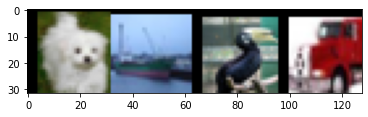

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  dog   ship  bird  truck


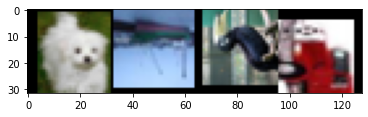

Rotation labels:  0     180   90    270  


In [6]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [7]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            
            # TODO: unsure which dim should use
            _, predicted = torch.max(outputs, 1)
            # update total & correct
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [8]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [9]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

device = torch.device("cuda:1") if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=1)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [19]:
import torch.optim as optim

# TODO: Define criterion and optimizer
lr = 0.01
momentum = 0.9
criterion = nn.CrossEntropyLoss() # criterion -> loss function
# optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(net.parameters(), lr=lr)

In [13]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            
            # forward
            net = net.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            # backward
            loss.backward()
            # optimize
            optimizer.step()

            # TODO: Get predicted results
            _, predicted = torch.max(outputs, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [20]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
# torch.save(net.state_dict(), 'ResNet18_model.pth')

[1,   100] loss: 1.493 acc: 32.02 time: 2.07
[1,   200] loss: 1.249 acc: 43.95 time: 1.90
[1,   300] loss: 1.179 acc: 47.96 time: 1.89
TESTING:
Accuracy of the network on the 10000 test images: 53.02 %
Average loss on the 10000 test images: 1.095
[2,   100] loss: 1.137 acc: 51.09 time: 2.09
[2,   200] loss: 1.120 acc: 51.66 time: 1.90
[2,   300] loss: 1.105 acc: 52.24 time: 1.91
TESTING:
Accuracy of the network on the 10000 test images: 55.88 %
Average loss on the 10000 test images: 1.044
[3,   100] loss: 1.069 acc: 54.50 time: 2.08
[3,   200] loss: 1.042 acc: 55.88 time: 1.89
[3,   300] loss: 1.037 acc: 55.30 time: 1.89
TESTING:
Accuracy of the network on the 10000 test images: 56.94 %
Average loss on the 10000 test images: 1.028
[4,   100] loss: 1.016 acc: 56.91 time: 2.06
[4,   200] loss: 1.002 acc: 57.56 time: 1.87
[4,   300] loss: 0.978 acc: 58.66 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 60.20 %
Average loss on the 10000 test images: 0.946
[5,   100] l

## Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [45]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

pre_trained_model_path = 'ResNet18_model.pth'
net = resnet18(num_classes=4, pretrained=False)
net = net.to(device)
state_dict = torch.load(pre_trained_model_path)
net.load_state_dict(state_dict)
net.eval()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(classes))

In [47]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable

# Freeze all previous layers
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [48]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [49]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
lr = 0.0001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum)

In [50]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=5, init_lr=0.01, task='classification')


[1,   100] loss: 1.522 acc: 46.86 time: 2.00
[1,   200] loss: 1.302 acc: 54.20 time: 1.86
[1,   300] loss: 1.240 acc: 56.32 time: 1.86
TESTING:
Accuracy of the network on the 10000 test images: 61.01 %
Average loss on the 10000 test images: 1.105
[2,   100] loss: 1.157 acc: 59.09 time: 2.08
[2,   200] loss: 1.166 acc: 58.95 time: 1.87
[2,   300] loss: 1.127 acc: 59.50 time: 1.85
TESTING:
Accuracy of the network on the 10000 test images: 63.95 %
Average loss on the 10000 test images: 1.017
[3,   100] loss: 1.080 acc: 61.07 time: 2.01
[3,   200] loss: 1.123 acc: 60.73 time: 1.84
[3,   300] loss: 1.084 acc: 61.77 time: 1.85
TESTING:
Accuracy of the network on the 10000 test images: 63.51 %
Average loss on the 10000 test images: 1.035
[4,   100] loss: 1.032 acc: 63.07 time: 2.03
[4,   200] loss: 1.048 acc: 62.91 time: 1.88
[4,   300] loss: 1.042 acc: 62.57 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 65.07 %
Average loss on the 10000 test images: 0.993
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [51]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model

net = resnet18(num_classes=10, pretrained=False)
net = net.to(device)

In [52]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.

# Freeze all previous layers
for name, param in net.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [53]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [54]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.

lr = 0.01
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum)

In [41]:
train(net, criterion, optimizer, num_epochs=40, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.154 acc: 23.48 time: 2.04
[1,   200] loss: 1.966 acc: 28.63 time: 1.89
[1,   300] loss: 1.930 acc: 30.09 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 34.80 %
Average loss on the 10000 test images: 1.816
[2,   100] loss: 1.867 acc: 32.33 time: 2.05
[2,   200] loss: 1.848 acc: 32.58 time: 1.87
[2,   300] loss: 1.822 acc: 34.61 time: 1.87
TESTING:
Accuracy of the network on the 10000 test images: 37.14 %
Average loss on the 10000 test images: 1.736
[3,   100] loss: 1.805 acc: 34.88 time: 2.03
[3,   200] loss: 1.789 acc: 35.70 time: 1.86
[3,   300] loss: 1.812 acc: 34.80 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 39.36 %
Average loss on the 10000 test images: 1.680
[4,   100] loss: 1.761 acc: 36.51 time: 2.04
[4,   200] loss: 1.779 acc: 35.72 time: 1.90
[4,   300] loss: 1.766 acc: 36.39 time: 1.90
TESTING:
Accuracy of the network on the 10000 test images: 39.61 %
Average loss on the 10000 test images: 1.665
[5,   100] l

## Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [15]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model

pre_trained_model_path = 'ResNet18_model.pth'
net = resnet18(num_classes=4, pretrained=False)
net = net.to(device)
state_dict = torch.load(pre_trained_model_path)
net.load_state_dict(state_dict)

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, len(classes))

In [16]:
# TODO: Define criterion and optimizer

lr = 0.01
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [17]:
train(net, criterion, optimizer, num_epochs=60, decay_epochs=20, init_lr=0.01, task='classification')

[1,   100] loss: 1.419 acc: 50.20 time: 2.08
[1,   200] loss: 1.189 acc: 58.62 time: 1.89
[1,   300] loss: 1.079 acc: 62.54 time: 1.91
TESTING:
Accuracy of the network on the 10000 test images: 65.65 %
Average loss on the 10000 test images: 0.985
[2,   100] loss: 0.969 acc: 65.82 time: 2.06
[2,   200] loss: 0.948 acc: 66.51 time: 1.90
[2,   300] loss: 0.933 acc: 67.12 time: 1.91
TESTING:
Accuracy of the network on the 10000 test images: 69.88 %
Average loss on the 10000 test images: 0.876
[3,   100] loss: 0.853 acc: 69.84 time: 2.09
[3,   200] loss: 0.858 acc: 69.96 time: 1.91
[3,   300] loss: 0.841 acc: 70.23 time: 1.91
TESTING:
Accuracy of the network on the 10000 test images: 72.50 %
Average loss on the 10000 test images: 0.812
[4,   100] loss: 0.801 acc: 71.64 time: 2.08
[4,   200] loss: 0.777 acc: 72.48 time: 1.94
[4,   300] loss: 0.774 acc: 72.73 time: 1.91
TESTING:
Accuracy of the network on the 10000 test images: 73.82 %
Average loss on the 10000 test images: 0.776
[5,   100] l

## Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [64]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model

net = resnet18(num_classes=10, pretrained=False)
net = net.to(device)

In [65]:
# TODO: Define criterion and optimizer

lr = 0.001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [66]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.053 acc: 26.84 time: 2.05
[1,   200] loss: 1.699 acc: 37.98 time: 1.88
[1,   300] loss: 1.591 acc: 41.96 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 47.75 %
Average loss on the 10000 test images: 1.444
[2,   100] loss: 1.430 acc: 47.80 time: 2.05
[2,   200] loss: 1.384 acc: 49.88 time: 1.88
[2,   300] loss: 1.332 acc: 52.10 time: 1.88
TESTING:
Accuracy of the network on the 10000 test images: 55.49 %
Average loss on the 10000 test images: 1.226
[3,   100] loss: 1.237 acc: 55.75 time: 2.05
[3,   200] loss: 1.181 acc: 57.93 time: 1.87
[3,   300] loss: 1.157 acc: 59.18 time: 1.89
TESTING:
Accuracy of the network on the 10000 test images: 62.08 %
Average loss on the 10000 test images: 1.068
[4,   100] loss: 1.077 acc: 61.70 time: 2.05
[4,   200] loss: 1.054 acc: 62.62 time: 1.87
[4,   300] loss: 1.057 acc: 62.28 time: 1.87
TESTING:
Accuracy of the network on the 10000 test images: 65.64 %
Average loss on the 10000 test images: 0.963
[5,   100] l